In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import gc

In [3]:
# Configurar TensorFlow para evitar problemas de memoria con la GPU
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
tf.keras.mixed_precision.set_global_policy('mixed_float16')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


In [4]:
# Parámetros configurables
energies = ['1E2']  # Lista de energías a considerar
particles = ["Photon", "Proton"]  # Lista de partículas a considerar
base_dir = r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR_ChPT_Datasets"
predicts_dir = r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\ML_Predictions"

In [5]:
# Inicializar el scaler para normalizar los datos
scaler = MinMaxScaler()
all_data = []
all_sequences, all_angles, all_particles = [], [], []

In [6]:
def balance_angle_data(sequences, angles, particles, target_angle, particle_type, target_count=500, k=5):
    """
    Función para equilibrar los datos de un ángulo objetivo y tipo de partícula.
    Puede truncar o aumentar los datos (con un modelo de interpolación k-NN) según sea necesario.
    Además, verifica si el ángulo está presente en ambas distribuciones si hay más de una partícula.
    """
    # Verificar si hay más de una partícula en la lista
    if len(set(particles)) > 1:
        # Verificar si el ángulo está presente en ambas distribuciones
        photon_mask = (angles == target_angle) & (particles == 1)
        proton_mask = (angles == target_angle) & (particles == 0)
        
        if not (np.any(photon_mask) and np.any(proton_mask)):
            return np.array([]), np.array([]), np.array([])

    # Filtrar datos del ángulo objetivo y tipo de partícula
    angle_mask = (angles == target_angle) & (particles == particle_type)
    X_angle = sequences[angle_mask]
    particle_labels = particles[angle_mask]
    
    if len(X_angle) == 0:
        return np.array([]), np.array([]), np.array([])

    # Truncar datos si hay más que el objetivo
    if len(X_angle) > target_count:
        selected_indices = np.random.choice(len(X_angle), target_count, replace=False)
        X_angle = X_angle[selected_indices]
        particle_labels = particle_labels[selected_indices]

    # Aumentar datos si hay menos que el objetivo
    elif len(X_angle) < target_count:
        n_new_samples = target_count - len(X_angle)
        
        if len(X_angle) < 2:  # Necesitamos al menos 2 muestras para interpolación
            return np.array([]), np.array([]), np.array([])

        # Asegurar que k sea válido (al menos 1 y menos que el número de muestras)
        k = max(1, min(k, len(X_angle) - 1))
        
        # Aplanar las secuencias
        n_samples, time_steps, n_features = X_angle.shape
        X_flat = X_angle.reshape(n_samples, -1)
        
        # Entrenar modelo de vecinos
        knn = NearestNeighbors(n_neighbors=k+1).fit(X_flat)  # +1 para incluir el punto mismo
        
        new_sequences = []
        for _ in range(n_new_samples):
            base_idx = np.random.randint(0, len(X_angle))
            base_sample = X_flat[base_idx]
            
            # Encontrar vecinos (incluyendo el punto mismo)
            _, indices = knn.kneighbors(base_sample.reshape(1, -1))
            
            # Filtrar el punto base y asegurar que hay vecinos
            neighbor_indices = [i for i in indices[0] if i != base_idx]
            if not neighbor_indices:  # Si no hay vecinos válidos
                continue
                
            neighbor_idx = np.random.choice(neighbor_indices)
            neighbor_sample = X_flat[neighbor_idx]
            
            # Interpolación
            alpha = np.random.uniform(0.2, 0.8)
            synthetic_flat = base_sample * alpha + neighbor_sample * (1 - alpha)
            synthetic_seq = synthetic_flat.reshape(time_steps, n_features)
            
            # Ruido y restricciones físicas
            noise = np.random.normal(0, 0.01, size=synthetic_seq.shape)
            new_seq = synthetic_seq + noise
            new_seq[:, 3] = np.abs(new_seq[:, 3])  # particle_count ≥ 0
            new_seq[:, 2] = np.sort(new_seq[:, 2])  # mantener orden temporal
            
            new_sequences.append(new_seq)
        
        # Agregar las nuevas secuencias
        if new_sequences:
            X_angle = np.concatenate([X_angle, np.array(new_sequences)])
            particle_labels = np.concatenate([particle_labels, np.full(len(new_sequences), particle_type)])

    # Crear el array de ángulos equilibrados
    balanced_angles = np.full(len(X_angle), target_angle)
    return X_angle, balanced_angles, particle_labels

In [7]:
# Leer datos de distintas energías y partículas
for energy in energies:
    for particle in particles:
        input_base_dir = os.path.join(base_dir, f"CONDOR_{energy}_{particle}_ChPt", "binned_data")
        
        if not os.path.exists(input_base_dir):
            print("Error de directorio:", input_base_dir)
            continue  # Si no existe, pasar a la siguiente carpeta
        
        print(f"Procesando datos de {energy} {particle}...")
        
        for run_folder in os.listdir(input_base_dir):
            run_path = os.path.join(input_base_dir, run_folder)
            if not os.path.isdir(run_path) or "run_" not in run_folder:
                continue
            
            for csv_file in os.listdir(run_path):
                if csv_file.endswith(".csv"):
                    csv_path = os.path.join(run_path, csv_file)
                    if os.stat(csv_path).st_size == 0:
                        continue
                    
                    try:
                        angle = float(csv_file.split("_")[7])
                    except (IndexError, ValueError):
                        continue
                    
                    binned_data = pd.read_csv(csv_path)
                    all_data.append(binned_data[['x_bin', 'y_bin', 't_bin', 'particle_count']].values)

# Ajustar el scaler con todos los datos disponibles
if all_data:
    scaler.fit(np.vstack(all_data))

Procesando datos de 1E2 Photon...
Procesando datos de 1E2 Proton...


In [8]:
# Calcular automáticamente time_steps basado en el promedio de la longitud de los datasets en run_1 (ángulo 0°)
run_1_lengths = []

for energy in energies:
    for particle in particles:
        input_base_dir = os.path.join(base_dir, f"CONDOR_{energy}_{particle}_ChPt", "binned_data", "run_1")
        
        if not os.path.exists(input_base_dir):
            continue
        
        for csv_file in os.listdir(input_base_dir):
            if csv_file.endswith(".csv"):
                csv_path = os.path.join(input_base_dir, csv_file)
                if os.stat(csv_path).st_size == 0:
                    continue
                
                binned_data = pd.read_csv(csv_path)
                run_1_lengths.append(len(binned_data))

if run_1_lengths:
    time_steps = int(np.mean(run_1_lengths))
    print(f"Time steps calculados automáticamente: {time_steps}")
else:
    print("No se encontraron datos en run_1 para calcular time_steps.")
    exit()

# Segunda pasada: leer y normalizar los datos
for energy in energies:
    for particle in particles:
        input_base_dir = os.path.join(base_dir, f"CONDOR_{energy}_{particle}_ChPt", "binned_data")
        
        if not os.path.exists(input_base_dir):
            continue  
        
        for run_folder in os.listdir(input_base_dir):
            run_path = os.path.join(input_base_dir, run_folder)
            if not os.path.isdir(run_path) or "run_" not in run_folder:
                continue
            
            for csv_file in os.listdir(run_path):
                if csv_file.endswith(".csv"):
                    csv_path = os.path.join(run_path, csv_file)
                    if os.stat(csv_path).st_size == 0:
                        continue
                    
                    try:
                        angle = float(csv_file.split("_")[7])
                    except (IndexError, ValueError):
                        continue
                    
                    binned_data = pd.read_csv(csv_path)
                    data = binned_data[['x_bin', 'y_bin', 't_bin', 'particle_count']].values
                    data = scaler.transform(data)
                    
                    sequences = [data[i:i + time_steps] for i in range(len(data) - time_steps)]
                    
                    if sequences:
                        all_sequences.extend(sequences)
                        all_angles.extend([angle] * len(sequences))
                        particle_label = 0 if particle == "Proton" else 1
                        all_particles.extend([particle_label] * len(sequences))

if not all_sequences:
    print("No se encontraron datos suficientes para entrenar el modelo.")
    exit()

Time steps calculados automáticamente: 11


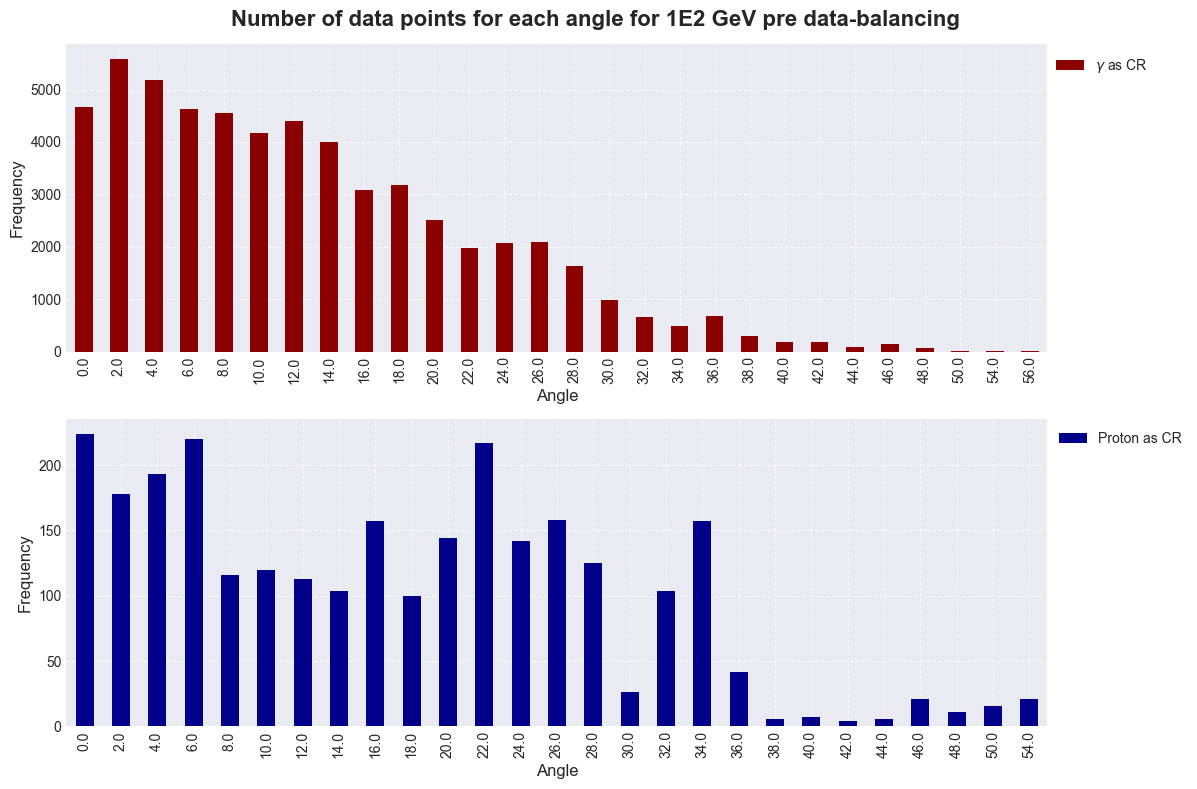

In [9]:
# Convertir listas en arrays para facilitar el filtrado
all_angles = np.array(all_angles)
all_particles = np.array(all_particles)

# Filtrar datos por tipo de partícula
photon_angles = all_angles[all_particles == 1]
proton_angles = all_angles[all_particles == 0]

# Crear series para los ángulos
photon_angle_series = pd.Series(photon_angles)
proton_angle_series = pd.Series(proton_angles)

# Contar la frecuencia de cada ángulo
photon_angle_counts = photon_angle_series.value_counts(sort=False).sort_index()
proton_angle_counts = proton_angle_series.value_counts(sort=False).sort_index()

plt.style.use('seaborn-v0_8-darkgrid')  # Corrected style name

# Crear gráficos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Gráfico para fotones
if not photon_angle_counts.empty:
    photon_angle_counts.plot(kind='bar', ax=axes[0], color='darkred', legend=True, label='$\gamma$ as CR')
    axes[0].set_xlabel('Angle', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].legend(fontsize=10, loc='upper right', bbox_to_anchor=(1.115, 1))
    axes[0].grid(True, linestyle='--', alpha=0.7)
else:
    axes[0].text(0.5, 0.5, 'No data for Photons', fontsize=14, ha='center', va='center')
    axes[0].set_axis_off()

# Gráfico para protones
if not proton_angle_counts.empty:
    proton_angle_counts.plot(kind='bar', ax=axes[1], color='darkblue', legend=True, label='Proton as CR')
    axes[1].set_xlabel('Angle', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].legend(fontsize=10, loc='upper right', bbox_to_anchor=(1.15, 1))
    axes[1].grid(True, linestyle='--', alpha=0.7)
else:
    axes[1].text(0.5, 0.5, 'No data for Protons', fontsize=14, ha='center', va='center')
    axes[1].set_axis_off()

fig.suptitle(f'Number of data points for each angle for {energy} GeV pre data-balancing', fontsize=16, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


In [10]:
# Definir el número objetivo de datos por ángulo
target_count = 500

# Truncar o aumentar los datos de cada ángulo
balanced_sequences = []
balanced_angles = []
balanced_particles = []

unique_angles = np.unique(all_angles)

for angle in unique_angles:
    for particle_type in [0, 1]:  # 0 para Proton, 1 para Photon
        # Aplicar la función balance_angle_data
        balanced_seq, balanced_ang, balanced_part = balance_angle_data(
            np.array(all_sequences), 
            np.array(all_angles), 
            np.array(all_particles), 
            target_angle=angle, 
            particle_type=particle_type, 
            target_count=target_count, 
            k=5
        )
        
        if len(balanced_seq) > 0:
            balanced_sequences.append(balanced_seq)
            balanced_angles.append(balanced_ang)
            balanced_particles.append(balanced_part)

# Combinar los datos balanceados
all_sequences = np.concatenate(balanced_sequences)
all_angles = np.concatenate(balanced_angles)
all_particles = np.concatenate(balanced_particles)

print(f"Datos balanceados: {len(all_sequences)} muestras")


KeyboardInterrupt: 

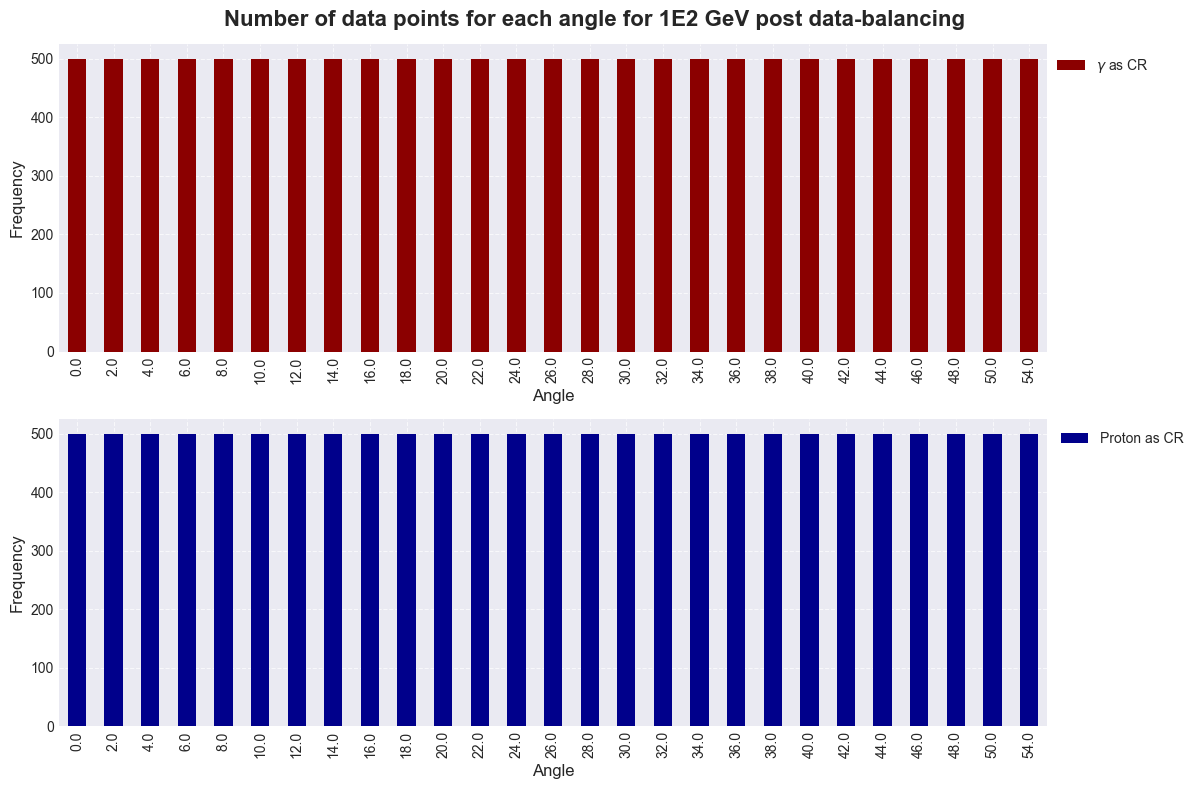

In [ ]:
all_angles = np.array(all_angles)
all_particles = np.array(all_particles)

# Filtrar datos por tipo de partícula
photon_angles = all_angles[all_particles == 1]
proton_angles = all_angles[all_particles == 0]

# Crear series de pandas para los ángulos
photon_angle_series = pd.Series(photon_angles)
proton_angle_series = pd.Series(proton_angles)

# Contar la frecuencia de cada ángulo
photon_angle_counts = photon_angle_series.value_counts(sort=False).sort_index()
proton_angle_counts = proton_angle_series.value_counts(sort=False).sort_index()

# Aplicar estilo científico
plt.style.use('seaborn-v0_8-darkgrid')  # Corrected style name

# Crear gráficos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Gráfico para fotones
if not photon_angle_counts.empty:
    photon_angle_counts.plot(kind='bar', ax=axes[0], color='darkred', legend=True, label='$\gamma$ as CR')
    axes[0].set_xlabel('Angle', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].legend(fontsize=10, loc='upper right', bbox_to_anchor=(1.115, 1))
    axes[0].grid(True, linestyle='--', alpha=0.7)
else:
    axes[0].text(0.5, 0.5, 'No data for Photons', fontsize=14, ha='center', va='center')
    axes[0].set_axis_off()

# Gráfico para protones
if not proton_angle_counts.empty:
    proton_angle_counts.plot(kind='bar', ax=axes[1], color='darkblue', legend=True, label='Proton as CR')
    axes[1].set_xlabel('Angle', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].legend(fontsize=10, loc='upper right', bbox_to_anchor=(1.15, 1))
    axes[1].grid(True, linestyle='--', alpha=0.7)
else:
    axes[1].text(0.5, 0.5, 'No data for Protons', fontsize=14, ha='center', va='center')
    axes[1].set_axis_off()

# Título general
fig.suptitle(f'Number of data points for each angle for {energy} GeV post data-balancing', fontsize=16, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


In [ ]:
all_sequences = np.array(all_sequences)
all_angles = np.array(all_angles)
all_particles = np.array(all_particles)

# Dividir en conjuntos de entrenamiento y validación
train_sequences, val_sequences, train_angles, val_angles, train_particles, val_particles = train_test_split(
    all_sequences, all_angles, all_particles, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.metrics import f1_score

import tensorflow.keras.backend as K# Definir métrica F1-Score
def f1_metric(y_true, y_pred):
    y_pred_binary = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred_binary, 'float'), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred_binary), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred_binary, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred_binary), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    return K.mean(f1)

batch_size = 64
epochs = 200  # Aumentar épocas para mayor aprendizaje

# Definir modelo mejorado
input_shape = (time_steps, 4)

# Construir el modelo final con dos salidas
input_layer = layers.Input(shape=input_shape)
x = layers.Conv1D(128, kernel_size=2, activation='relu', padding='same')(input_layer)
x = layers.MaxPooling1D(pool_size=1)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(256, kernel_size=2, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(pool_size=1)(x)
x = layers.BatchNormalization()(x)
x = layers.LSTM(120, return_sequences=True, dropout=0.3)(x)
x = layers.LSTM(60, dropout=0.3)(x)

# Salida para la clasificación del tipo de partícula
particle_output = layers.Dense(32, activation='relu')(x)
particle_output = layers.Dense(1, activation='sigmoid', name='particle_output')(particle_output)

# Salida para la regresión del ángulo
angle_output = layers.Dense(32, activation='relu')(x)
angle_output = layers.Dense(1, activation='linear', name='angle_output')(angle_output)

# Verificar si hay datos de partículas
if train_particles.size > 0 and val_particles.size > 0:
    # Salida para la clasificación del tipo de partícula
    particle_output = layers.Dense(32, activation='relu')(x)
    particle_output = layers.Dense(1, activation='sigmoid', name='particle_output')(particle_output)

    # Definir el modelo con dos salidas
    model = models.Model(inputs=input_layer, outputs=[particle_output, angle_output])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={'particle_output': 'binary_crossentropy', 'angle_output': 'mse'},
        metrics={'particle_output': f1_metric, 'angle_output': 'mae'}
    )

    # Callbacks para mejorar el entrenamiento
    early_stopping = callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_particle_output_f1_metric', factor=0.5, patience=5, min_lr=1e-5)

    # Entrenar modelo
    history = model.fit(
        train_sequences, {'particle_output': train_particles, 'angle_output': train_angles},
        validation_data=(val_sequences, {'particle_output': val_particles, 'angle_output': val_angles}),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr]
    )
else:
    # Definir el modelo con una sola salida (ángulo)
    model = models.Model(inputs=input_layer, outputs=angle_output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    # Callbacks para mejorar el entrenamiento
    early_stopping = callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

    # Entrenar modelo
    history = model.fit(
        train_sequences, train_angles,
        validation_data=(val_sequences, val_angles),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr]
    )

# Guardar modelo
model_save_path = os.path.join(predicts_dir, 'LSTM_Optimized.h5')
model.save(model_save_path)
print(f"Modelo guardado en {model_save_path}")


Epoch 1/200
338/338 [==============================] - 12s 23ms/step - loss: inf - particle_output_loss: 0.6919 - angle_output_loss: inf - particle_output_f1_metric: 0.5020 - angle_output_mae: 9.2596 - val_loss: 194.2772 - val_particle_output_loss: 0.7384 - val_angle_output_loss: 193.5346 - val_particle_output_f1_metric: 0.6476 - val_angle_output_mae: 11.7117 - lr: 0.0010
Epoch 2/200
338/338 [==============================] - 8s 22ms/step - loss: 36.6827 - particle_output_loss: 0.6448 - angle_output_loss: 36.0380 - particle_output_f1_metric: 0.6419 - angle_output_mae: 4.4450 - val_loss: 52.4647 - val_particle_output_loss: 0.6173 - val_angle_output_loss: 51.8468 - val_particle_output_f1_metric: 0.7181 - val_angle_output_mae: 5.6559 - lr: 0.0010
Epoch 3/200
338/338 [==============================] - 7s 21ms/step - loss: 31.9802 - particle_output_loss: 0.5702 - angle_output_loss: 31.4098 - particle_output_f1_metric: 0.7136 - angle_output_mae: 4.0657 - val_loss: 26.2790 - val_particle_outp

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 11, 4)]      0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 11, 64)       576         ['input_7[0][0]']                
                                                                                                  
 max_pooling1d_12 (MaxPooling1D  (None, 11, 64)      0           ['conv1d_12[0][0]']              
 )                                                                                                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 11, 64)      256         ['max_pooling1d_12[0][0]'] 

In [ ]:
eval_results = model.evaluate(val_sequences, {'particle_output': val_particles, 'angle_output': val_angles}, verbose=1)
predictions = model.predict(val_sequences)

# Separar las predicciones para cada salida
particle_predictions = predictions[0].flatten()
angle_predictions = predictions[1].flatten()

# Guardar estadísticas
data_save_path = os.path.join(predicts_dir, 'LSTM_Stats.csv')
stats_df = pd.DataFrame({
    'True Particle': val_particles,
    'Predicted Particle': np.round(particle_predictions),
    'True Angle': val_angles,
    'Predicted Angle': angle_predictions,
    'Absolute Error Angle': np.abs(val_angles - angle_predictions)
})
stats_df.to_csv(data_save_path, index=False)

print(f"Estadísticas guardadas en {data_save_path}")
print(f"MAE: {eval_results[3]}, MSE: {eval_results[2]}, Accuracy: {eval_results[4]}")


169/169 [==============================] - 1s 4ms/step
Estadísticas guardadas en C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\ML_Predictions\LSTM_Stats.csv
MAE: 0.9279323816299438, MSE: 9.10931396484375, Accuracy: 1.824028730392456


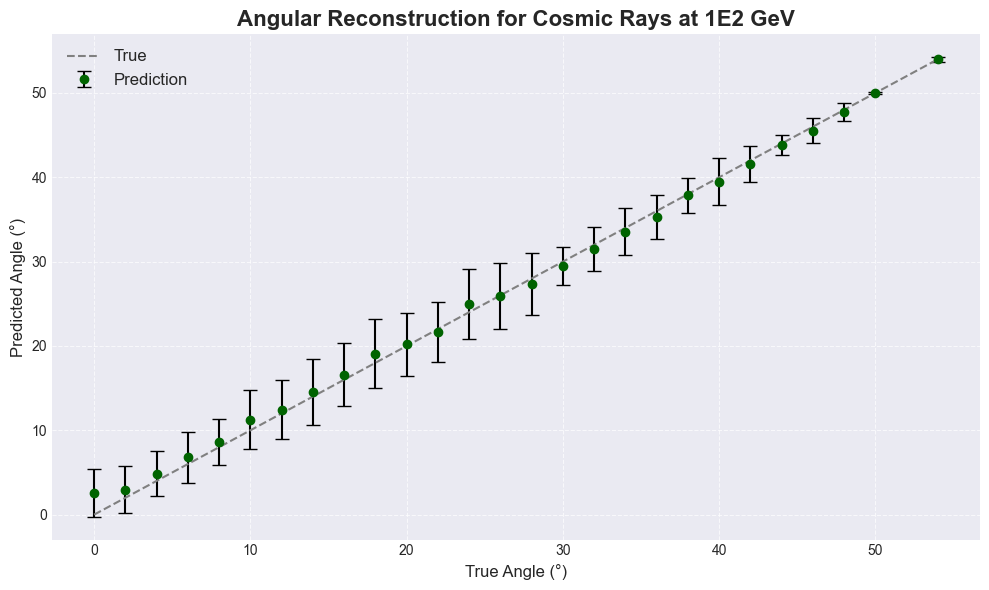

In [ ]:
# Visualización de resultados para todas las partículas
unique_angles = sorted(stats_df['True Angle'].unique())
predicted_means = stats_df.groupby('True Angle')['Predicted Angle'].mean()
error_bars = stats_df.groupby('True Angle')['Predicted Angle'].std()

plt.style.use('seaborn-v0_8-darkgrid')  # Corrected style name

fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de reconstrucción angular
ax.errorbar(unique_angles, predicted_means, yerr=error_bars, fmt='o', color='darkgreen', ecolor='k', capsize=5, label='Prediction')
ax.plot(unique_angles, unique_angles, linestyle='--', color='gray', label='True')

# Personalización del gráfico
ax.set_xlabel('True Angle (°)', fontsize=12)
ax.set_ylabel('Predicted Angle (°)', fontsize=12)
ax.set_title(f'Angular Reconstruction for Cosmic Rays at {energy} GeV', fontsize=16, weight='bold')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

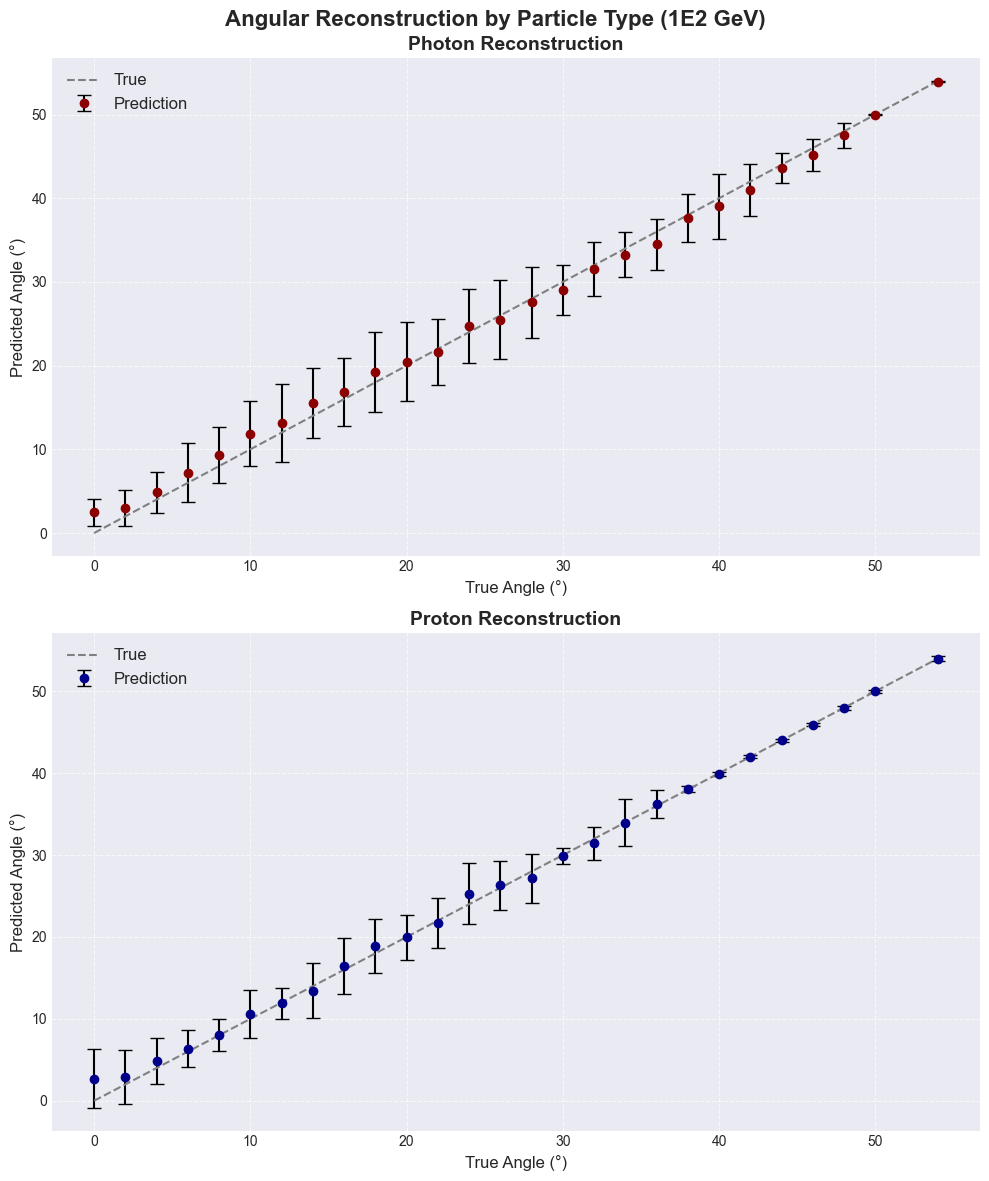

In [ ]:
# Gráfico 3: Predicción por ángulo para Protón
proton_stats = stats_df[stats_df['True Particle'] == 0]
unique_proton_angles = sorted(proton_stats['True Angle'].unique())
proton_predicted_means = proton_stats.groupby('True Angle')['Predicted Angle'].mean()
proton_error_bars = proton_stats.groupby('True Angle')['Predicted Angle'].std()

# Gráfico 4: Predicción por ángulo para Fotón
photon_stats = stats_df[stats_df['True Particle'] == 1]
unique_photon_angles = sorted(photon_stats['True Angle'].unique())
photon_predicted_means = photon_stats.groupby('True Angle')['Predicted Angle'].mean()
photon_error_bars = photon_stats.groupby('True Angle')['Predicted Angle'].std()

# Reconstrucción angular por partícula
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Reconstrucción para fotones
axes[0].errorbar(unique_photon_angles, photon_predicted_means, yerr=photon_error_bars, fmt='o', color='darkred', ecolor='k', capsize=5, label='Prediction')
axes[0].plot(unique_photon_angles, unique_photon_angles, linestyle='--', color='gray', label='True')
axes[0].set_xlabel('True Angle (°)', fontsize=12)
axes[0].set_ylabel('Predicted Angle (°)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(fontsize=12)
axes[0].set_title('Photon Reconstruction', fontsize=14, weight='bold')

# Reconstrucción para protones
axes[1].errorbar(unique_proton_angles, proton_predicted_means, yerr=proton_error_bars, fmt='o', color='darkblue', ecolor='k', capsize=5, label='Prediction')
axes[1].plot(unique_proton_angles, unique_proton_angles, linestyle='--', color='gray', label='True')
axes[1].set_xlabel('True Angle (°)', fontsize=12)
axes[1].set_ylabel('Predicted Angle (°)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(fontsize=12)
axes[1].set_title('Proton Reconstruction', fontsize=14, weight='bold')
fig.suptitle(f'Angular Reconstruction by Particle Type ({energy} GeV)', fontsize=16, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


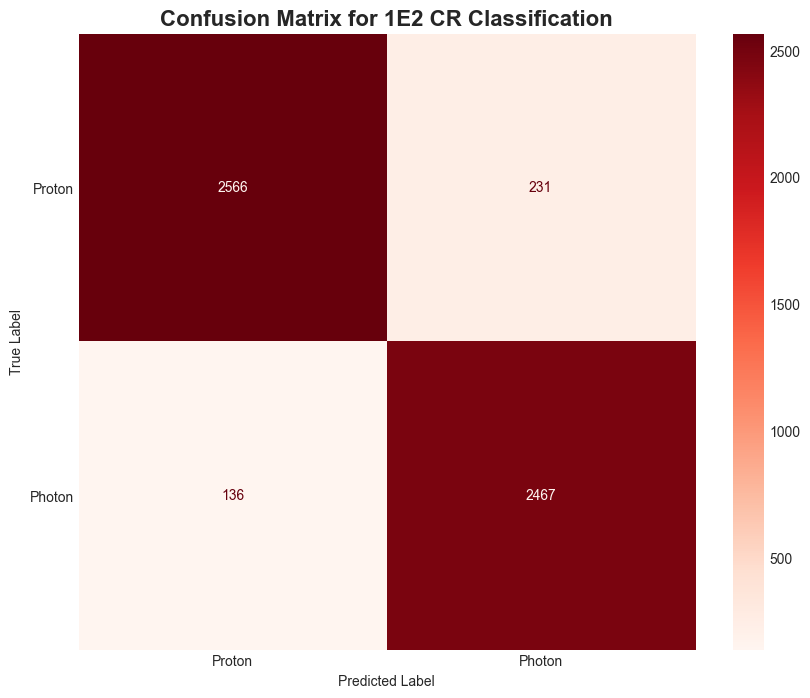

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.style.use('seaborn-v0_8-darkgrid') 

# Calcular la matriz de confusión
cm = confusion_matrix(val_particles, np.round(particle_predictions))

# Crear la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Proton", "Photon"])
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(
    ax=ax,
    cmap='Reds',
    colorbar=True
)

# Personalizar el gráfico
ax.set_title(f'Confusion Matrix for {energy} CR Classification', fontsize=16, weight='bold')
ax.set_xlabel('Predicted Label', fontsize=10)
ax.set_ylabel('True Label', fontsize=10)
plt.grid(False)
plt.show()

C:\Users\Froxo\AppData\Local\Temp\ipykernel_4940\2995639497.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  angle_accuracy = stats_df.groupby('True Angle').apply(


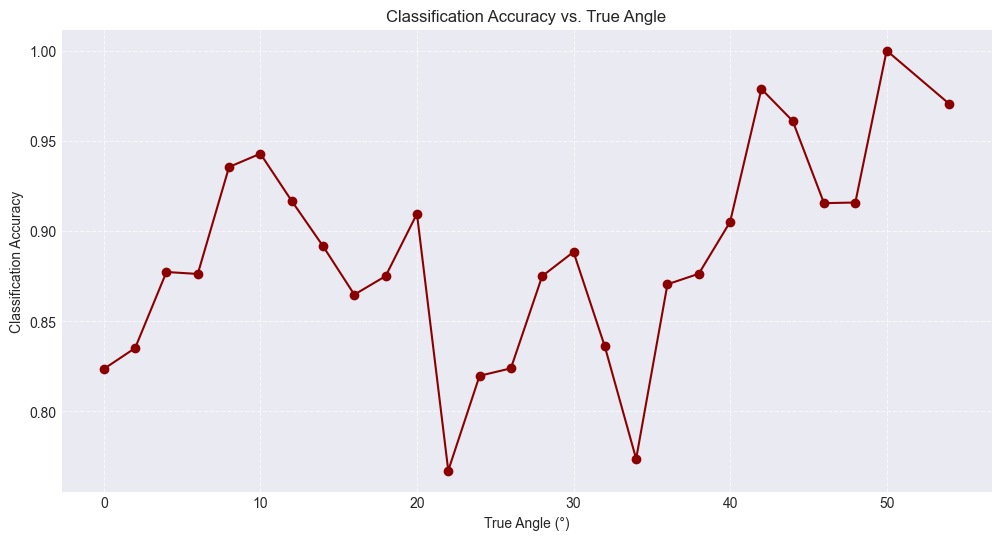

In [ ]:
# Calcular la precisión de la clasificación binaria para cada ángulo
angle_accuracy = stats_df.groupby('True Angle').apply(
    lambda df: (df['True Particle'] == df['Predicted Particle'].round()).mean()
)

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(angle_accuracy.index, angle_accuracy.values, marker='o', linestyle='-', color='darkred')
plt.xlabel('True Angle (°)')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy vs. True Angle')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()